In [1]:
import sys
sys.path.insert(0,'../..')
sys.path.insert(0,'splinter-python/python')

In [2]:
import matplotlib as mpl
mpl.use("pgf")

## TeX preamble
pgf_with_pdflatex = {
    "font.family": "serif",
    "text.usetex": True,
    "text.latex.unicode": True,
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage[]{libertine}"
         r"\usepackage[libertine]{newtxmath}"
         ]
}
mpl.rcParams.update(pgf_with_pdflatex)

mpl.rcParams['font.family'] = 'Libertine'

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Linux Libertine']})

import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='/usr/local/texlive/2017/texmf-dist/fonts/opentype/public/libertine/LinLibertine_DR.otf')

In [3]:
%load_ext line_profiler

In [4]:
import splinter
splinter.load('../../splinter-python/lib/linux/x86-64/libsplinter-3-0.so')

Unable to automatically locate SPLINTER.
You can load it manually by doing splinter.load("/path/to/SPLINTER.so")
Loaded SPLINTER from ../../splinter-python/lib/linux/x86-64/libsplinter-3-0.so!


In [5]:
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import pyplot as plt
plt.rc('text',usetex=True)
plt.rc('figure',figsize=(5.05,3.1),dpi=100)
plt.rc('text.latex',preamble=[r'\usepackage[]{libertine}',r'\usepackage[libertine]{newtxmath}'])
%matplotlib inline
#%matplotlib notebook

import numpy as np
from numba import njit
import multiprocessing as mp

import time

import os
import errno

from scipy.interpolate import RectBivariateSpline as RBS, interp1d as LS, CubicSpline as CS

from ipywidgets import FloatProgress
from IPython.display import display

In [6]:
#@njit
#def _ABC_flow(t,x,A,B,C):
#    return np.array([A*np.sin(x[:,:,:,2])+C*np.cos(x[:,:,:,1]),B*np.sin(x[:,:,:,0])+A*np.cos(x[:,:,:,2]),C*np.sin(x[:,:,:,1])+B*np.cos(x[:,:,:,0])])
#
#@njit
#def vel(t,x):
#    A = 1.#np.sqrt(3)
#    B = 1.#np.sqrt(2)
#    C = 1.
#    return _ABC_flow(t,x,A,B,C).transpose([1,2,3,0])

@njit
def vx(t,y,z):
    A = 1.
    B = 1.
    C = 1.
    return A*np.sin(z) + C*np.cos(y)

@njit
def vy(t,x,z):
    A = 1.
    B = 1.
    C = 1.
    return B*np.sin(x) + A*np.cos(z)

@njit
def vz(t,x,y):
    A = 1.
    B = 1.
    C = 1.
    return C*np.sin(y) + B*np.cos(x)

In [45]:
xmin,xmax = 0,2*np.pi
ymin,ymax = xmin,xmax
zmin,zmax = xmin,xmax

nx = 50
ny = 50
nz = 50

x,dx = np.linspace(xmin,xmax,nx,retstep=True)
y,dy = np.linspace(ymin,ymax,ny,retstep=True)
z,dz = np.linspace(zmin,zmax,nz,retstep=True)

In [8]:
def makegrid(x,y,z):
    return np.array(np.meshgrid(x,y,z,indexing='ij')).T.reshape(-1,3)

In [8]:
%timeit a = makegrid(x,y,z)

69.9 µs ± 2.93 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
a.shape

NameError: name 'a' is not defined

<IPython.core.display.Javascript object>


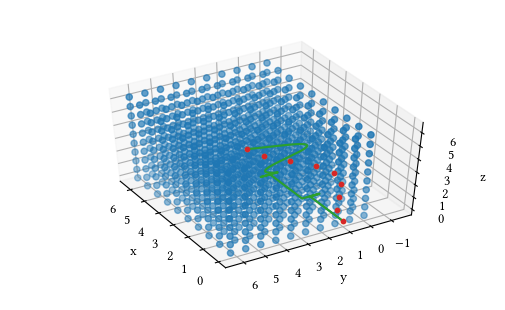

Text(0.5,0,'z')

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a[:,0],a[:,1],a[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [48]:
#def makegrid(x,y,z):
#    return np.array(np.meshgrid(z,y,x)).transpose(1,3,2,0).reshape(-1,3)

#def makegridinclauxpart(x,y,z,_dx,_dy,_dz):
#    _main_grid = makegrid(x,y,z)
#    grid = np.empty((7,*_main_grid.shape))
#    grid[0] = _main_grid
#    grid[1] = _main_grid + np.array([_dx,0,0])
#    grid[2] = _main_grid - np.array([_dx,0,0])
#    grid[3] = _main_grid + np.array([0,_dy,0])
#    grid[4] = _main_grid - np.array([0,_dy,0])
#    grid[5] = _main_grid + np.array([0,0,_dz])
#    grid[6] = _main_grid - np.array([0,0,_dz])
#    return grid


_dx = (xmax-xmin)/50
_dy = (ymax-ymin)/50
_dz = (zmax-zmin)/50


In [49]:
_nx = np.ceil((xmax-xmin)/_dx).astype(int)
_ny = np.ceil((ymax-ymin)/_dy).astype(int)
_nz = np.ceil((zmax-zmin)/_dz).astype(int)

sx = np.linspace(xmin,xmax,_nx)
sy = np.linspace(ymin,ymax,_ny)
sz = np.linspace(zmin,zmax,_nz)

def make_3d_interp(t,sx,sy,sz,v1,v2,v3):
    r,vx,vy,vz = make_lists_for_3d_interp(t,sx,sy,sz,v1,v2,v3)
    vx_spline = splinter.BSplineBuilder(r,vx,degree=[3,3,3],smoothing=splinter.BSplineBuilder.Smoothing.NONE).build()
    vy_spline = splinter.BSplineBuilder(r,vy,degree=[3,3,3],smoothing=splinter.BSplineBuilder.Smoothing.NONE).build()
    vz_spline = splinter.BSplineBuilder(r,vz,degree=[3,3,3],smoothing=splinter.BSplineBuilder.Smoothing.NONE).build()
    return vx_spline, vy_spline, vz_spline

def make_lists_for_3d_interp(t,sx,sy,sz,v1,v2,v3):
    r = makegrid(sx,sy,sz)
    vx = v1(t,r[:,1],r[:,2])
    vy = v2(t,r[:,0],r[:,2])
    vz = v3(t,r[:,0],r[:,1])
    return r.tolist(),vx.tolist(),vy.tolist(),vz.tolist()


In [21]:
def rk2_tricubic(t,pos,h,curr_vx,curr_vy,curr_vz,sx,sy,sz):
    k1 = np.array([curr_vx.eval(returntobox(pos)),curr_vy.eval(returntobox(pos)),curr_vz.eval(returntobox(pos))]).T
    nw_vx,nw_vy,nw_vz = make_3d_interp(t+h,sx,sy,sz,vx,vy,vz)
    k2 = np.array([nw_vx.eval(returntobox(pos+k1*h)),nw_vy.eval(returntobox(pos+k1*h)),nw_vz.eval(returntobox(pos+k1*h))]).T
    return pos + (k1+k2)*h/2.,nw_vx,nw_vy,nw_vz
    
    
def tricubic_advection(t0,pos_in,h,tf,sx,sy,sz):
    pos_f = np.copy(pos_in)
    curr_vx,curr_vy,curr_vz = make_3d_interp(t0,sx,sy,sz,vx,vy,vz)
    for j in range(np.ceil((tf-t0)/h).astype(int)):
        pos_f,curr_vx,curr_vy,curr_vz = rk2_tricubic(t0+j*h,pos_f,h,curr_vx,curr_vy,curr_vz,sx,sy,sz)
    return pos_f

def rk2_analytical(t,pos,h):
    k1 = np.array([vx(t,returntobox(pos[:,1]),returntobox(pos[:,2])),vy(t,returntobox(pos[:,0]),returntobox(pos[:,2])),vz(t,returntobox(pos[:,0]),returntobox(pos[:,1]))]).T
    k2 = np.array([vx(t+h,returntobox(pos[:,1]+k1[:,1]*h),returntobox(pos[:,2]+k1[:,2]*h)),vy(t+h,returntobox(pos[:,0]+k1[:,0]*h),returntobox(pos[:,2]+k1[:,2]*h)),vz(t+h,returntobox(pos[:,0]+k1[:,0]*h),returntobox(pos[:,1]+k1[:,1]*h))]).T
    return pos+(k1+k2)*h/2.

def analytical_advection(t0,pos_in,h,tf):
    pos_f = np.copy(pos_in)
    for j in range(np.ceil((tf-t0)/h).astype(int)):
        pos_f = rk2_analytical(t0+j*h,pos_f,h)
    return pos_f
    

In [26]:
pos_in = makegrid(x,y,z)
t0=0.
tf=1.
h=0.1

%timeit pos_f = tricubic_advection(t0,pos_in,h,tf,sx,sy,sz)

5.98 s ± 57.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
sx.shape

(11,)

In [49]:
%timeit pos_f_a = analytical_advection(t0,pos_in,h,tf)

9.95 ms ± 19.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
%lprun -f rk2_tricubic tricubic_advection(t0,pos_in,h,tf,sx,sy,sz)

In [50]:
pos_f_a = analytical_advection(t0,pos_in,h,tf)

In [12]:
def returntobox(pos):
    return pos - np.divmod(pos,2*np.pi)[0]*2*np.pi

In [35]:
returntobox([3*np.pi,5*np.pi])[0]

3.1415926535897931

In [87]:
pos_fin = tricubic_advection(t0,pos_in,h,tf,sx,sy,sz)

0.9


In [53]:
np.sqrt(np.sum((pos_f-pos_f_a)**2))

0.19301362137537895

Text(0.5,0,'z')

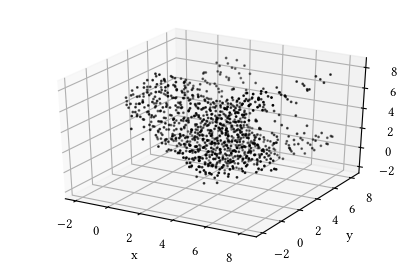

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_f[:,0],pos_f[:,1],pos_f[:,2],c='k',s=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

Text(0.5,0,'z')

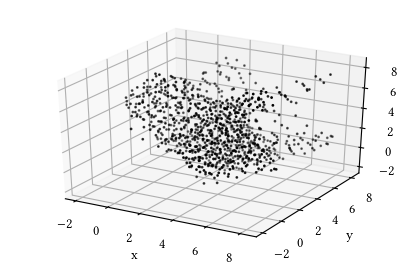

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_f_a[:,0],pos_f_a[:,1],pos_f_a[:,2],c='k',s=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [ ]:
#g

In [144]:
#g2 = makegridinclauxpart(x,y,z,_dx,_dy,_dz)

In [ ]:
sx

In [48]:
qz = np.linspace(0,2*np.pi,10000)

In [49]:
rz = np.array((np.zeros(len(qz)),np.ones(len(qz)),qz)).reshape(-1,3).tolist()

In [50]:
np.array((np.zeros(len(qz)),np.ones(len(qz)),qz)).shape

(3, 10000)

In [ ]:
velx,vely,velz = make_3d_interp(0,sx,sy,sz,vx,vy,vz)

In [ ]:
np.shape(velx.get_control_points())

<IPython.core.display.Javascript object>


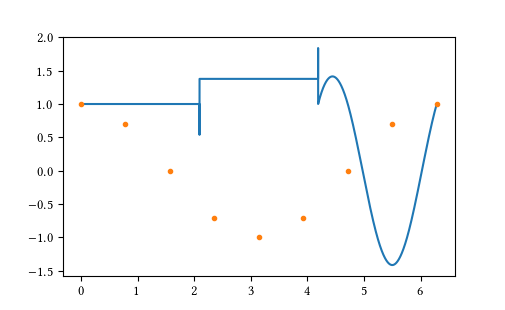

In [56]:
plt.plot(qz,qy)
plt.plot(sz,vy(0,0,sz),'.')
plt.show()

In [57]:
qy

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [61]:
vy(0,0,sz)

array([ 1.        ,  0.76604444,  0.17364818, -0.5       , -0.93969262,
       -0.93969262, -0.5       ,  0.17364818,  0.76604444,  1.        ])

In [63]:
vely.eval(np.array((np.zeros(sz.size),np.zeros(sz.size),sz)).reshape(-1,3))

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.14278760968653942,
 -0.1579798566743316,
 0.015192246987791865]

In [322]:
def advect_analytical(tstart,tend,grid,vel,h):
    t = np.ones(grid.shape[0])*tstart
    for j in range(np.ceil((tend-tstart)/h).astype(int)):
        for k in range(grid.shape[0]):
            t[k],grid[k],h = rk2(t[k],grid[k],h,vel)
    return grid

In [323]:
g = makegridinclauxpart(x,y,z,_dx,_dy,_dz)
g.shape

(7, 10, 10, 10, 3)

<IPython.core.display.Javascript object>


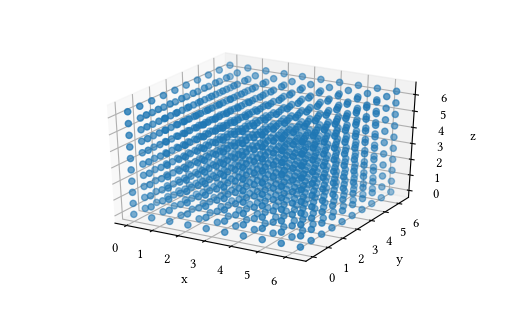

Text(0.5,0,'z')

In [325]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(g[0,:,:,:,0],g[0,:,:,:,1],g[0,:,:,:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [328]:
start = time.time()
g2 = advect_analytical(0,1,np.copy(g),vel,0.1)
mins,secs = np.divmod(time.time()-start,60)
print('Advection took {} minutes and {} seconds'.format(mins,secs))

TypingError: Failed at nopython (nopython frontend)
Failed at nopython (nopython frontend)
array(float64, 3d, C) not allowed in a homogenous sequence
[1] During: resolving callee type: Function(<built-in function array>)
[2] During: typing of call at <ipython-input-327-427c3622b9a3> (3)
[3] During: resolving callee type: type(CPUDispatcher(<function _ABC_flow at 0x7f485ab0d0d0>))
[4] During: typing of call at <ipython-input-327-427c3622b9a3> (10)

<IPython.core.display.Javascript object>


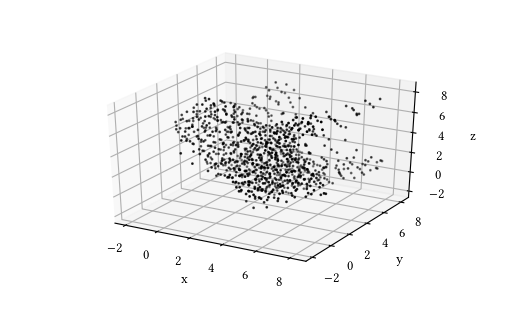

Text(0.5,0,'z')

In [200]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(np.divmod(g2[0,:,:,:,0],2*np.pi)[1],np.divmod(g2[0,:,:,:,1],2*np.pi)[1],np.divmod(g2[0,:,:,:,2],2*np.pi)[1],color='k',s=1)
ax.scatter(g2[0,:,:,:,0],g2[0,:,:,:,1],g2[0,:,:,:,2],c='k',s=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [260]:
def periodic_collapse(x):
    return x - np.divmod(x,2*np.pi)[0]*2*np.pi

In [329]:
# Sampling grid
ds = xmax/100

_nx = np.ceil(xmax/ds).astype(int)
_ny = np.ceil(ymax/ds).astype(int)
_nz = np.ceil(zmax/ds).astype(int)

_n = _nx*_ny*_nz

sx = np.linspace(xmin,xmax,_nx)
sy = np.linspace(ymin,ymax,_ny)
sz = np.linspace(zmin,zmax,_nz)

@njit
def velocity_sample_planes(t,sx,sy,sz):
    collection = np.empty((sx.shape[0],sy.shape[0],sz.shape[0],3))
    for k in range(sy.shape[0]):
        for l in range(sz.shape[0]):
            collection[:,k,l,0] = vx(t,np.array([sx[0],sy[k],sz[l]]))
    for j in range(sx.shape[0]):
        for l in range(sz.shape[0]):
            collection[j,:,l,1] = vy(t,np.array([sx[j],sy[0],sz[l]]))
    for j in range(sx.shape[0]):
        for k in range(sy.shape[0]):
            collection[j,k,:,2] = vz(t,np.array([sx[j],sy[k],sz[0]]))
    return collection

In [330]:
%timeit a = velocity_sample_planes(0,sx,sy,sz)

27.6 ms ± 608 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [275]:
_ny

99.99999999999999

In [279]:
sz

array([ 0.        ,  0.06346652,  0.12693304,  0.19039955,  0.25386607,
        0.31733259,  0.38079911,  0.44426563,  0.50773215,  0.57119866,
        0.63466518,  0.6981317 ,  0.76159822,  0.82506474,  0.88853126,
        0.95199777,  1.01546429,  1.07893081,  1.14239733,  1.20586385,
        1.26933037,  1.33279688,  1.3962634 ,  1.45972992,  1.52319644,
        1.58666296,  1.65012947,  1.71359599,  1.77706251,  1.84052903,
        1.90399555,  1.96746207,  2.03092858,  2.0943951 ,  2.15786162,
        2.22132814,  2.28479466,  2.34826118,  2.41172769,  2.47519421,
        2.53866073,  2.60212725,  2.66559377,  2.72906028,  2.7925268 ,
        2.85599332,  2.91945984,  2.98292636,  3.04639288,  3.10985939,
        3.17332591,  3.23679243,  3.30025895,  3.36372547,  3.42719199,
        3.4906585 ,  3.55412502,  3.61759154,  3.68105806,  3.74452458,
        3.8079911 ,  3.87145761,  3.93492413,  3.99839065,  4.06185717,
        4.12532369,  4.1887902 ,  4.25225672,  4.31572324,  4.37

In [280]:
g.shape

(7, 10, 10, 10, 3)

In [316]:
g.transpose([0,1,3,2,4])

array([[[[[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
          [  0.00000000e+00,   6.98131701e-01,   0.00000000e+00],
          [  0.00000000e+00,   1.39626340e+00,   0.00000000e+00],
          ..., 
          [  0.00000000e+00,   4.88692191e+00,   0.00000000e+00],
          [  0.00000000e+00,   5.58505361e+00,   0.00000000e+00],
          [  0.00000000e+00,   6.28318531e+00,   0.00000000e+00]],

         [[  0.00000000e+00,   0.00000000e+00,   6.98131701e-01],
          [  0.00000000e+00,   6.98131701e-01,   6.98131701e-01],
          [  0.00000000e+00,   1.39626340e+00,   6.98131701e-01],
          ..., 
          [  0.00000000e+00,   4.88692191e+00,   6.98131701e-01],
          [  0.00000000e+00,   5.58505361e+00,   6.98131701e-01],
          [  0.00000000e+00,   6.28318531e+00,   6.98131701e-01]],

         [[  0.00000000e+00,   0.00000000e+00,   1.39626340e+00],
          [  0.00000000e+00,   6.98131701e-01,   1.39626340e+00],
          [  0.00000000e+00,   1.3962634

In [20]:
a = [1,2,3]
b = [4,5,6]
c = [7,8,9]

In [21]:
np.array(np.meshgrid(a,b,c)).T.reshape(-1,3)

array([[1, 4, 7],
       [1, 5, 7],
       [1, 6, 7],
       [2, 4, 7],
       [2, 5, 7],
       [2, 6, 7],
       [3, 4, 7],
       [3, 5, 7],
       [3, 6, 7],
       [1, 4, 8],
       [1, 5, 8],
       [1, 6, 8],
       [2, 4, 8],
       [2, 5, 8],
       [2, 6, 8],
       [3, 4, 8],
       [3, 5, 8],
       [3, 6, 8],
       [1, 4, 9],
       [1, 5, 9],
       [1, 6, 9],
       [2, 4, 9],
       [2, 5, 9],
       [2, 6, 9],
       [3, 4, 9],
       [3, 5, 9],
       [3, 6, 9]])

In [24]:
q = np.array(np.meshgrid(x,y,z)).T.reshape(-1,3)

In [34]:
q.tolist()

[[0.0, 0.0, 0.0],
 [0.0, 0.6981317007977318, 0.0],
 [0.0, 1.3962634015954636, 0.0],
 [0.0, 2.0943951023931953, 0.0],
 [0.0, 2.792526803190927, 0.0],
 [0.0, 3.490658503988659, 0.0],
 [0.0, 4.1887902047863905, 0.0],
 [0.0, 4.886921905584122, 0.0],
 [0.0, 5.585053606381854, 0.0],
 [0.0, 6.283185307179586, 0.0],
 [0.6981317007977318, 0.0, 0.0],
 [0.6981317007977318, 0.6981317007977318, 0.0],
 [0.6981317007977318, 1.3962634015954636, 0.0],
 [0.6981317007977318, 2.0943951023931953, 0.0],
 [0.6981317007977318, 2.792526803190927, 0.0],
 [0.6981317007977318, 3.490658503988659, 0.0],
 [0.6981317007977318, 4.1887902047863905, 0.0],
 [0.6981317007977318, 4.886921905584122, 0.0],
 [0.6981317007977318, 5.585053606381854, 0.0],
 [0.6981317007977318, 6.283185307179586, 0.0],
 [1.3962634015954636, 0.0, 0.0],
 [1.3962634015954636, 0.6981317007977318, 0.0],
 [1.3962634015954636, 1.3962634015954636, 0.0],
 [1.3962634015954636, 2.0943951023931953, 0.0],
 [1.3962634015954636, 2.792526803190927, 0.0],
 [1.39

In [7]:
a = np.array([0,2])

In [10]:
a[1] = a[0]
a[1] = 3
a

array([0, 3])

In [14]:
z

array([ 0.        ,  0.6981317 ,  1.3962634 ,  2.0943951 ,  2.7925268 ,
        3.4906585 ,  4.1887902 ,  4.88692191,  5.58505361,  6.28318531])

In [15]:
r = np.array(np.meshgrid(x,y,z)).T.reshape(-1,3)

In [16]:
r

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.6981317 ,  0.        ],
       [ 0.        ,  1.3962634 ,  0.        ],
       ..., 
       [ 6.28318531,  4.88692191,  6.28318531],
       [ 6.28318531,  5.58505361,  6.28318531],
       [ 6.28318531,  6.28318531,  6.28318531]])

In [17]:
r.shape

(1000, 3)

In [108]:
rho = np.array(np.meshgrid(z,x,y)).transpose(1,3,2,0).reshape(-1,3)

In [109]:
rho.shape

(1000, 3)

In [113]:
rho[2]

array([ 1.3962634,  0.       ,  0.       ])

In [199]:
a = np.array([[1,2+3j,1],[9,3j,8],[0,2,4],[1j,3j,0]])

In [200]:
a

array([[ 1.+0.j,  2.+3.j,  1.+0.j],
       [ 9.+0.j,  0.+3.j,  8.+0.j],
       [ 0.+0.j,  2.+0.j,  4.+0.j],
       [ 0.+1.j,  0.+3.j,  0.+0.j]])

In [201]:
u,s,v = np.linalg.svd(a)
S = np.zeros((u.shape[1],v.shape[0]))
S[:s.size,:s.size] = np.diag(s)

In [202]:
assert np.all(np.equal(a,np.dot(u,np.dot(S,v))))

AssertionError: 

In [203]:
#s = np.diag(s)
np.dot(u,np.dot(S,v))

array([[  1.00000000e+00 +2.72004641e-15j,
          2.00000000e+00 +3.00000000e+00j,
          1.00000000e+00 -2.22044605e-15j],
       [  9.00000000e+00 -1.00627514e-16j,
         -1.31838984e-16 +3.00000000e+00j,
          8.00000000e+00 +4.44089210e-16j],
       [  1.77635684e-15 -3.88578059e-15j,
          2.00000000e+00 -1.11022302e-15j,
          4.00000000e+00 +4.44089210e-15j],
       [  2.27595720e-15 +1.00000000e+00j,
          1.77635684e-15 +3.00000000e+00j,
         -2.77555756e-15 -4.49640325e-15j]])

In [198]:
S.shape

(4, 3)

In [172]:
a

array([[ 1.+0.j,  2.+3.j,  1.+0.j],
       [ 9.+0.j,  0.+3.j,  8.+0.j],
       [ 0.+0.j,  2.+0.j,  4.+0.j]])

In [174]:
np.matrix(a).H

matrix([[ 1.-0.j,  9.-0.j,  0.-0.j],
        [ 2.-3.j,  0.-3.j,  2.-0.j],
        [ 1.-0.j,  8.-0.j,  4.-0.j]])

In [210]:
a = np.diag([1,2,1])

In [211]:
a

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 1]])

In [212]:
u,s,v = np.linalg.svd(a)

In [213]:
u

array([[ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.]])

In [214]:
s

array([ 2.,  1.,  1.])

In [215]:
v

array([[ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.]])

In [216]:
q = np.dot(a.T,a)

In [217]:
q

array([[1, 0, 0],
       [0, 4, 0],
       [0, 0, 1]])

In [218]:
vals,vecs = np.linalg.eigh(q)

In [219]:
vals

array([ 1.,  1.,  4.])

In [220]:
vecs

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.]])

In [221]:
np.dot(q,[0,1,0])

array([0, 4, 0])

In [227]:
u[:,0]

array([ 0.,  1.,  0.])

In [226]:
s[0]**2

4.0

In [228]:
evecs = u
evals = s

idx = np.argsort(evals)

In [229]:
idx

array([1, 2, 0])

In [230]:
evecs = evecs[idx]

In [231]:
evecs

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [232]:
evals

array([ 2.,  1.,  1.])

In [233]:
evecs = u
evecs = evecs[:,idx]

In [234]:
evecs

array([[ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.]])

In [7]:
(2*np.pi)**3

248.05021344239853